# Inventory Monitoring at Distribution Centers

Keeping track of your Inventory is fundamental to your success in retail. At the most basic level your job is to supply the products to meet consumer demand. You cannot do that without effective inventory management.

Inventory systems suffer from several problems. Some of the more common issues include stock outs, excess inventory, misplaced inventory, and employee errors.

In other hands, manual Inventory Management requires a huge workforce, and it is also error prone. So, there is a need for an effective inventory management.

The problem faced by the company is they do not have (or at least they do not have yet) any systematic system to record and keep their inventory data. It is difficult for the administrator to record the inventory data quickly and safely because they only keep it in the register and not meticulously organized. Therefore, it is difficult for the admin to estimate their profit.

With the new system developed, companies can manage their inventory data easily, quickly, and more secured. We could solve the above problem with machine automated tasks, Computer Vision Process aids us in solving the defined problem.

The problem is identified as a **classification problem** and upon given an input image, **the count of the objects in the bin can be predicted using the machine learning model**. 
> This notebook walks through the solution of the identified problem.


## A.1 Import and Install required packages

In [2]:
import argparse
import numpy as np
import json
import logging
import os
import io
import sys
import matplotlib.pyplot as plt
import requests
from PIL import Image
import json
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
!pip install --upgrade pip

  Using cached pip-22.1.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [4]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [5]:
!pip install torch --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 240.6 MB/s eta 0:00:0000:0100:01


In [6]:
!pip install torchvision

  Using cached torchvision-0.12.0-cp37-cp37m-manylinux1_x86_64.whl (21.0 MB)


In [7]:
import boto3
import torch
import time
import uuid
import os
import json
import smdebug
import sagemaker
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils import data
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [8]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

## Let's download and display our data.
download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:38,  7.73it/s]

  0%|          | 1/2299 [00:00<06:05,  6.29it/s]

  0%|          | 1/2666 [00:00<05:10,  8.58it/s]

  0%|          | 1/2373 [00:00<04:14,  9.32it/s]

  0%|          | 1/1875 [00:00<03:10,  9.86it/s]

100%|██████████| 1875/1875 [03:18<00:00,  9.43it/s]


After downloading images, wenoticd that data are unbalanced, let's plot some distributions tobe certain.

{'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}


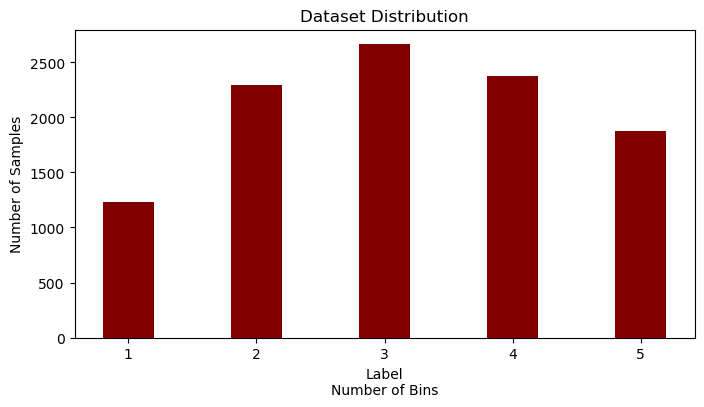

In [8]:
## Let's plot data distribution of the umber of samples regart to the number of bins.

def plot_samples_bins():
    data = {}
    for item in sorted(os.listdir(os.path.join(os.getcwd(), 'train_data/'))):
        data[item] =  len(os.listdir(os.path.join(os.getcwd(), f'train_data/{item}')))
        
    #for key, value in data.items():
    #     try:
    #         data[key] = int(value)
    #    except ValueError:
    #        item[key] = float(value) # use here str(value)
    print(data)
    object_count = list(data.keys())
    #print(data)
    no_of_samples = list(data.values())
    fig = plt.figure(figsize = (8, 4))
    
    # creating the bar plot
    plt.bar(object_count, no_of_samples, color ='maroon',width = 0.4)
    
    plt.xlabel("Label\nNumber of Bins")
    plt.ylabel("Number of Samples")
    plt.title("Dataset Distribution")
    return fig, data
        
a, _ = plot_samples_bins()
a

In [9]:
_, total_items = plot_samples_bins()
total_items

A = sum(x for x in total_items.values())
A

{'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}


10441

## Dataset
To train our model, we will use The `Amazon Bin Image Dataset`. It contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. 

Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers. 

Documentation about the open source dataset can be found [here](https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds).

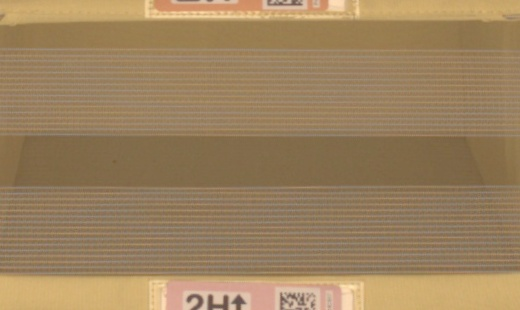

In [10]:
# Let's visualize some iamages 

img_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/109.jpg" }
img_bytes = requests.get(img_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [11]:
bucket = 'udacity-awsmle-capstone-project-2022'

os.environ['SM_CHANNEL_TRAINING']='s3://udacity-awsmle-capstone-project-2022/'
os.environ['SM_MODEL_DIR']='s3://udacity-awsmle-capstone-project-2022/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacity-awsmle-capstone-project-2022/output/'

checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

output_path = 's3://{}/{}'.format(bucket, 'model/')

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

print('Outpointing Path: {}'.format(output_path))

Checkpointing Path: s3://udacity-awsmle-capstone-project-2022/checkpoint-fb99ae24
Outpointing Path: s3://udacity-awsmle-capstone-project-2022/model/


In [13]:
%%capture
start_time = time.time()
!aws s3 cp train_data s3://udacity-awsmle-capstone-project-2022/ --recursive

print(f"\n Elapsed time: {time.time() - start_time}")

## Model Training

**Note:** We use the `train.py` script to train your model.

### Set-up parameters, estimator, and tuner.

In [12]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": CategoricalParameter([10,15, 25 , 30 ])    
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [13]:
sagemaker_session = sagemaker.Session()

estimator = PyTorch(
    sagemaker_session=sagemaker_session,
    entry_point="tuner.py",
    base_job_name='Capstone-awsmle-hpo-job',
    role=role,
    #output_path=output_path,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.2xlarge", # "ml.m5.xlarge"
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

### Fit the tuner

In [14]:
start_time = time.time()
tuner.fit({"training": "s3://udacity-awsmle-capstone-project-2022/"})

print(f"\n Elapsed time: {time.time() - start_time}")

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!

 Elapsed time: 4197.904114484787


In [16]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-220526-0705',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:310754713715:hyper-parameter-tuning-job/pytorch-training-220526-0705',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 2,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"', '"256"']},
    {'Name': 'epochs', 'Values': ['"10"', '"15"', '"25"', '"30"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator

In [17]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=tuner.describe()['HyperParameterTuningJobName'])

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""","""25""",0.001052,pytorch-training-220526-0705-002-b6f4feb0,Completed,91.0,2022-05-26 07:06:34+00:00,2022-05-26 08:12:27+00:00,3953.0
1,"""32""","""25""",0.001213,pytorch-training-220526-0705-001-99f30a60,Completed,47.0,2022-05-26 07:06:37+00:00,2022-05-26 07:36:06+00:00,1769.0


In [18]:
best_estimator=tuner.best_estimator()


2022-05-26 07:36:06 Starting - Preparing the instances for training
2022-05-26 07:36:06 Downloading - Downloading input data
2022-05-26 07:36:06 Training - Training image download completed. Training in progress.
2022-05-26 07:36:06 Uploading - Uploading generated training model
2022-05-26 07:36:06 Completed - Training job completed


In [19]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'epochs': '"25"',
 'learning_rate': '0.0012128565992639416',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Capstone-awsmle-hpo-job-2022-05-26-07-05-00-441"',
 'sagemaker_program': '"tuner.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-310754713715/Capstone-awsmle-hpo-job-2022-05-26-07-05-00-441/source/sourcedir.tar.gz"'}

In [20]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": float(best_estimator.hyperparameters()['learning_rate']),
                  "epochs":int(best_estimator.hyperparameters()['epochs'].replace('"', ''))}
hyperparameters

{'batch_size': 32, 'learning_rate': 0.0012128565992639416, 'epochs': 25}

In [21]:
best_estimator_training_jobname = best_estimator.hyperparameters().get('sagemaker_job_name').replace('"', '')
best_estimator_training_jobname

'Capstone-awsmle-hpo-job-2022-05-26-07-05-00-441'

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [22]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1",
    }
)


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)

In [23]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]


hook_config = DebuggerHookConfig(
    # hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
    collection_configs=collection_config_list
)

In [24]:
# Create and fit an estimator
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()
estimator_best = PyTorch(
    sagemaker_session=sagemaker_session,
    entry_point='train.py',
    base_job_name='Capstone-awsmle-on-demand-instance-job',
    role=role,
    #output_path=output_path,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [25]:
start_time = time.time()
estimator_best.fit({"training": "s3://udacity-awsmle-capstone-project-2022/"}, wait=True)

print(f"\n Elapsed time: {time.time() - start_time}")

2022-05-26 11:04:14 Starting - Starting the training job...
2022-05-26 11:04:41 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-05-26 11:06:01 Downloading - Downloading input data..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-26 11:08:24,318 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-26 11:08:24,322 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-05-26 11:08:24,335 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-26 11:08:24,338 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-26 11:08:24,769 sagemaker-containers INFO     Module default_user_module_n

In [26]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator_best.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-05-26 12:02:56.136 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:20 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-05-26 12:02:56.150 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-310754713715/Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/debug-output
[2022-05-26 12:02:58.129 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:20 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-05-26 12:02:59.152 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:20 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 'layer3.4.relu_input_2',
 'layer3.5.relu_input_0',
 'layer3

In [27]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [28]:
steps_eval, vals_eval = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.EVAL)
vals_eval

[array(1.3837729, dtype=float32),
 array(1.4289672, dtype=float32),
 array(1.5230616, dtype=float32),
 array(1.3024287, dtype=float32),
 array(1.4094629, dtype=float32),
 array(1.3719505, dtype=float32),
 array(1.367505, dtype=float32),
 array(1.47682, dtype=float32),
 array(1.3182902, dtype=float32),
 array(1.4072348, dtype=float32),
 array(1.4298025, dtype=float32),
 array(1.5391629, dtype=float32),
 array(1.3325404, dtype=float32),
 array(1.3426777, dtype=float32),
 array(1.4975355, dtype=float32),
 array(1.4246883, dtype=float32),
 array(1.4183272, dtype=float32),
 array(1.507717, dtype=float32),
 array(1.465557, dtype=float32),
 array(1.5142119, dtype=float32),
 array(1.430906, dtype=float32),
 array(1.7122729, dtype=float32),
 array(1.369891, dtype=float32),
 array(1.5141045, dtype=float32),
 array(1.4481806, dtype=float32),
 array(1.4701085, dtype=float32),
 array(1.3581313, dtype=float32),
 array(1.3666553, dtype=float32),
 array(1.5158617, dtype=float32),
 array(1.4851764, dty

In [29]:
steps_train, vals_train = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.TRAIN)
vals_train

[array(1.6512935, dtype=float32),
 array(1.54482, dtype=float32),
 array(1.6202402, dtype=float32),
 array(1.5812955, dtype=float32),
 array(1.5175452, dtype=float32),
 array(1.5426803, dtype=float32),
 array(1.5967995, dtype=float32),
 array(1.4531003, dtype=float32),
 array(1.5203072, dtype=float32),
 array(1.5409446, dtype=float32),
 array(1.532941, dtype=float32),
 array(1.4576492, dtype=float32),
 array(1.4760739, dtype=float32),
 array(1.4221236, dtype=float32),
 array(1.6027647, dtype=float32),
 array(1.4818344, dtype=float32),
 array(1.3665006, dtype=float32),
 array(1.4633346, dtype=float32),
 array(1.4636301, dtype=float32),
 array(1.4609432, dtype=float32),
 array(1.4116431, dtype=float32),
 array(1.5851277, dtype=float32),
 array(1.4478083, dtype=float32),
 array(1.3931634, dtype=float32),
 array(1.4819676, dtype=float32),
 array(1.3145592, dtype=float32),
 array(1.5713681, dtype=float32),
 array(1.4028643, dtype=float32),
 array(1.5582241, dtype=float32),
 array(1.4479656,

[2022-05-26 12:03:26.910 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-310754713715/Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/debug-output
[2022-05-26 12:03:27.123 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:20 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 213 more expected)', IncompleteRead(0 bytes read, 213 more expected)) while reading s3://sagemaker-us-east-1-310754713715/Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/debug-output/index/000000000/000000000150_worker_0.json . Will retry now
[2022-05-26 12:03:28.425 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:20 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-05-26 12:03:29.447 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca12

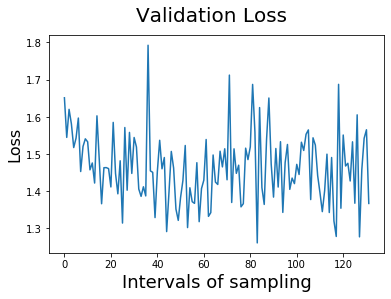

In [30]:
import matplotlib.pyplot as plt


from smdebug.trials import create_trial
from smdebug import modes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Get the tensors from S3
s3_output_path = estimator_best.latest_job_debugger_artifacts_path()

# Create a Trial https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#Trial
trial = create_trial(s3_output_path)

# Get all the tensor names
trial.tensor_names()

# Get the values of the tensor `val_acc`for mode GLOBAL (validation accuracy)
values = trial.tensor("CrossEntropyLoss_output_0").values(modes.GLOBAL)

# Convert it to numpy array
values_eval = np.array(list(values.items()))

fig = plt.figure()
plt.plot(values_eval[:, 1])
fig.suptitle('Validation Loss', fontsize=20)
plt.xlabel('Intervals of sampling', fontsize=18)
plt.ylabel('Loss', fontsize=16)
fig.savefig('validation_loss.jpg')

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("Train Data Loaded")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("Eval Data Loaded")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Generated TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Generated EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

Train Data Loaded
Eval Data Loaded
Generated TRAIN plot
Generated EVAL plot


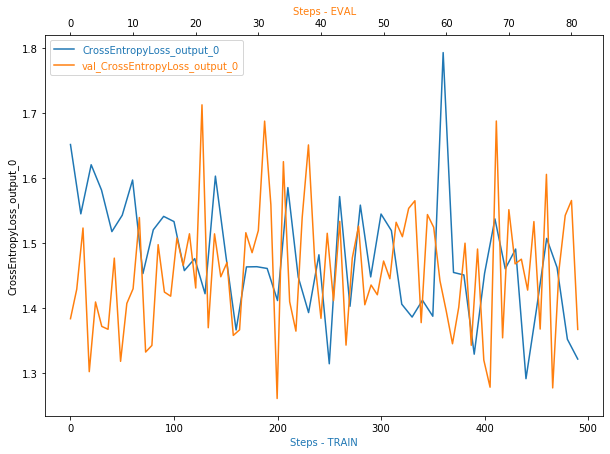

In [32]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

### Profil Report

In [33]:
# Display the profiler output
import os

rule_output_path = estimator_best.output_path + estimator_best.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-310754713715/Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/rule-output
2022-05-26 11:58:05     329711 Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-05-26 11:58:04     171074 Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-05-26 11:58:01        192 Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-05-26 11:58:01        200 Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-05-26 11:58:01        126 Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-05-26 11:58:01  

In [34]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_best.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [35]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [36]:
# TODO: Deploy your model to an endpoint
estimator_best.model_data

's3://sagemaker-us-east-1-310754713715/Capstone-awsmle-on-demand-instance-job-2022-05-26-11-04-14-023/output/model.tar.gz'

In [37]:
model_location=estimator_best.model_data

In [38]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [39]:
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [40]:
start_time = time.time()
predictor = pytorch_model.deploy(initial_instance_count=1, 
                                 instance_type='ml.m5.large')

print(f"\n Elapsed time: {time.time() - start_time}")

------!
 Elapsed time: 188.5962426662445


### Model Querying

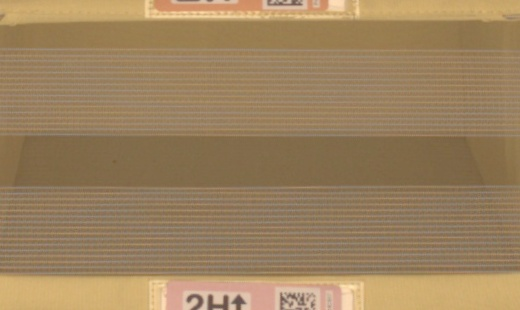

In [41]:
from PIL import Image
img_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/109.jpg" }
img_bytes = requests.get(img_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [42]:
from IPython.display import Image

In [43]:
response=predictor.predict(json.dumps(img_dict), initial_args={"ContentType": "application/json"})
response[0]

[2.019524335861206,
 0.9235374331474304,
 -0.18961110711097717,
 -1.1246399879455566,
 -2.012255907058716]

In [44]:
np.argmax(response, 1)

array([0])

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [45]:
# TODO: Cost Analysis

In [49]:
# TODO: Train your model using a spot instance

use_spot_instances = True
max_run=5000
max_wait = 10000 if use_spot_instances else None

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

estimator_spot = PyTorch(
    sagemaker_session=sagemaker_session,
    entry_point='train.py',
    base_job_name='Capstone-awsmle-Spot-instance-job',
    role=role,
    #output_path=output_path,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait
)

In [50]:
start_time = time.time()
estimator_spot.fit({"training": "s3://udacity-awsmle-capstone-project-2022/"}, wait=True)

print(f"\n Elapsed time: {time.time() - start_time}")

2022-05-26 14:09:25 Starting - Starting the training job...
2022-05-26 14:09:27 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-05-26 14:11:15 Starting - Preparing the instances for training......
2022-05-26 14:12:15 Downloading - Downloading input data.........
2022-05-26 14:13:56 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-26 14:14:05,689 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-26 14:14:05,693 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-05-26 14:14:05,703 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-26 14:14:08,745 sagemaker_pytorch_container.tr

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [51]:
# Train your model on Multiple Instances
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()
#hyperparameters={'batch_size': 64, 'learning_rate': 0.00808066447186899, 'epochs': 25}

multi_instance = PyTorch(
    base_job_name="Capstone-awsmle-Multi-instance-job",
    sagemaker_session=sagemaker_session,
    entry_point="train.py",
    role=role,
    #output_path=output_path,
    framework_version="1.4.0",
    py_version="py3",
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [52]:
start_time = time.time()
multi_instance.fit({"training": "s3://udacity-awsmle-capstone-project-2022/"}, wait=True)

print(f"\n Elapsed time: {time.time() - start_time}")

2022-05-26 15:06:48 Starting - Starting the training job...
2022-05-26 15:07:18 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-05-26 15:08:39 Downloading - Downloading input data............
2022-05-26 15:10:43 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-26 15:10:46,577 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-26 15:10:46,580 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-05-26 15:10:46,591 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-26 15:10:46,596 sagemaker_pytorch_container.training INFO     Invoking user training scr